# Practical Deep Learning for Coders, v3

# Lesson 1_pets

# What's your pet 

# 你的宠物是什么

Welcome to lesson 1! For those of you who are using a Jupyter Notebook for the first time, you can learn about this useful tool in a tutorial we prepared specially for you; click `File`->`Open` now and click `00_notebook_tutorial.ipynb`. <br>

欢迎来到第1课！如果你是首次使用Jupyter Notebook，你可以通过阅读我们特别为你准备的教程来学习这个有用的工具：即刻点击`File`->`Open`然后点击`00_notebook_tutorial.ipynb`即可。

In this lesson we will build our first image classifier from scratch, and see if we can achieve world-class results. Let's dive in!<br>

在这节课中，我们将从零开始构建我们自己的首个图像分类器，看看是否能够取得世界级的成果。就让我们一探究竟吧！

Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.<br>

每一个notebook都由下面三行开始；它们确保你对库代码进行任何编辑，这些代码都将自动重新加载，并且任何图表或图片能在notebook中展示。

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.<br>

我们首先导入所有需要的包，然后就可以使用构建于 [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163)之上的 [fastai V1库](http://www.fast.ai/2018/10/02/fastai-ai/)。fastai库提供了大量有用的函数，可以帮助我们简单快捷地构建神经网络，并且训练出我们的模型。

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.<br>

如果你的计算机GPU内存非常小，在运行notebook时，你很可能会碰到内存溢出的错误。如果这种情况发生了，点击Kernel->Restart，然后去除对下面第2行的注释，使用更小的*batch size*（批次大小，你将在课程中全面了解其含义），然后再试着运行一下。

In [3]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data 浏览一下数据

We are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these 37 distinct categories. According to their paper, the best accuracy they could get in 2012 was 59.21%, using a complex model that was specific to pet detection, with separate "Image", "Head", and "Body" models for the pet photos. Let's see how accurate we can be using deep learning!<br>

我们将使用由 [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf)引用的[Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/)数据集，这个数据集中有12个品种的猫和25个品种的狗。我们的模型需要学会正确区分这37个品种。根据上述学者的论文描述，他们能取得的最佳分类准确率是59.21%。这个结果是基于一个专门检测宠物品种的复杂模型得到的，这个模型对宠物的照片分别建立了“肖像”、“头部”以及“躯干”的独立模型。让我们来看看，使用深度学习能够达到什么样的准确率吧!

We are going to use the `untar_data` function to which we must pass a URL as an argument and which will download and extract the data.<br>

我们将通过引用一个URL参数来调用`untar_data`函数，这样就可以下载和解压相应数据。

In [4]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url: str, fname: Union[pathlib.Path, str] = None, dest: Union[pathlib.Path, str] = None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if `dest` doesn't exist, and un-tgz to folder `dest`.



In [5]:
path = untar_data(URLs.PETS); path

PosixPath('/root/.fastai/data/oxford-iiit-pet')

In [6]:
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [7]:
path_anno = path/'annotations'
path_img = path/'images'

The first thing we do when we approach a problem is to take a look at the data. We *always* need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.<br>

当我们解决特定问题时，首先要做的是浏览一下数据。在想清楚最终如何解决一个问题之前，我们 *总是* 要深入理解问题和数据究竟意味着什么。浏览一下数据，意味着理解数据的内容和结构，分类标签是什么，样本图片是什么样的。

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html).<br>

图片分类数据处理方式的最主要区别是标签存储方式。在这个数据集中，标签本身就存在于文件名之中。我们需要将标签信息提取出来，从而将这些图片分门别类。幸运的是，fastai库提供了一个非常好用的函数来实现这一点，`ImageDataBunch.from_name_re`函数通过使用[正则表达式](https://docs.python.org/3.6/library/re.html) 从文件名中提取标签信息。

In [8]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/pomeranian_121.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/japanese_chin_56.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/chihuahua_29.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/miniature_pinscher_84.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Sphynx_194.jpg')]

In [9]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [10]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

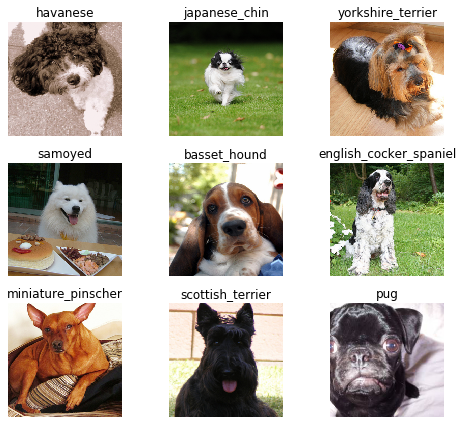

In [11]:
data.show_batch(rows=3, figsize=(7,6))

In [12]:
print(data.classes)
len(data.classes),data.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

## Training: resnet34    

## 训练：resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).<br>

现在我们将要开始训练模型了。我们将使用一个 [卷积神经网络](http://cs231n.github.io/convolutional-networks/) 作为主干结构，衔接一个单隐藏层的全连接头部，构成分类器模型。不理解这些是什么意思吗?不用担心，我们在接下来的课程中会做更深入的讲解。当下，你只需要理解，我们正在构建一个模型，这个模型接收图片作为输入，并且能够输出各个品种的预测概率（在我们这个案例中，共有37个数）。

We will train for 4 epochs (4 cycles through all our data).<br>

我们将训练4个epochs（即4个遍历所有数据的循环）。

In [13]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:02<00:00, 42.9MB/s]


In [14]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [15]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.332795,0.392407,0.127876,09:22
1,0.576019,0.305236,0.100135,08:46


KeyboardInterrupt: 

In [ ]:
learn.save('stage-1')

## Results 结果

Let's see what results we have got. <br>

让我们来看看结果如何。

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. <br>

我们首先看到的是模型最混淆的品种。我们要试着思考一下，模型预测的是否合理。在这个案例里，模型的错误分类看起来是合理的（没有犯明显的低级错误）。这意味着我们的分类器做的不错。

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.<br>

而且，当我们绘制出（识别品种）的混淆矩阵时，我们可以看到数据分布是偏态的：模型会不断地重复相同的错误，但是很少会混淆其他品种。这意味着模型难以正确区分一些具体的品种；这是正常表现。

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

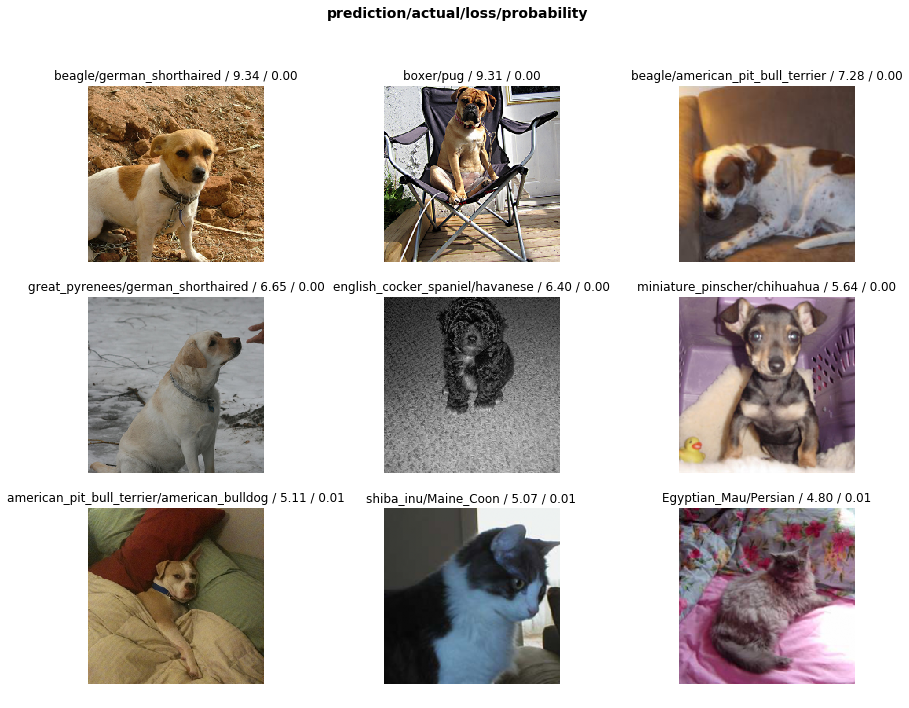

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

In [ ]:
doc(interp.plot_top_losses)

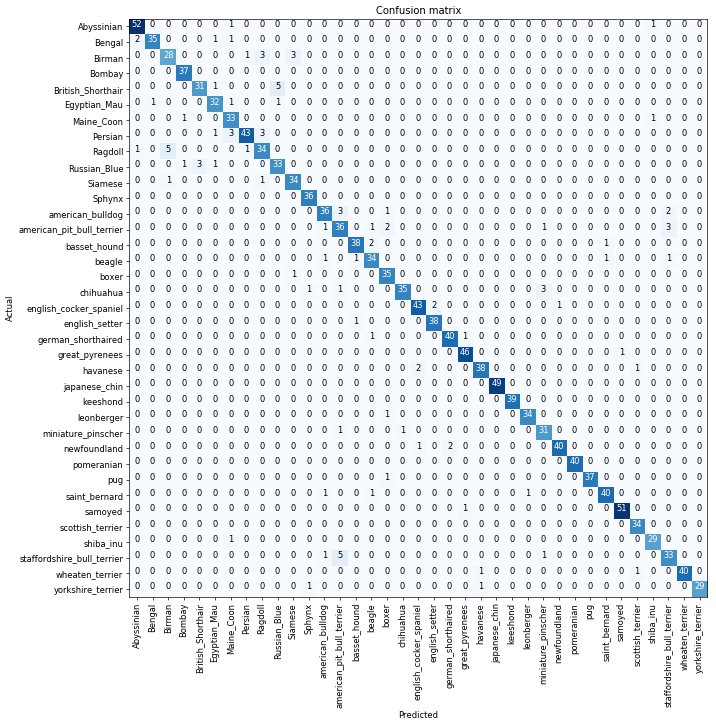

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=2)

[('British_Shorthair', 'Russian_Blue', 5),
 ('Ragdoll', 'Birman', 5),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 5),
 ('Birman', 'Ragdoll', 3),
 ('Birman', 'Siamese', 3),
 ('Persian', 'Maine_Coon', 3),
 ('Persian', 'Ragdoll', 3),
 ('Russian_Blue', 'British_Shorthair', 3),
 ('american_bulldog', 'american_pit_bull_terrier', 3),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 3),
 ('chihuahua', 'miniature_pinscher', 3)]

## Unfreezing, fine-tuning, and learning rates 

## 解冻，调优和学习率

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.<br>

既然我们的模型表现符合我们的预期，我们将*解冻* 模型并继续训练。

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate
1,0.558166,0.314579,0.101489


In [ ]:
learn.load('stage-1');

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


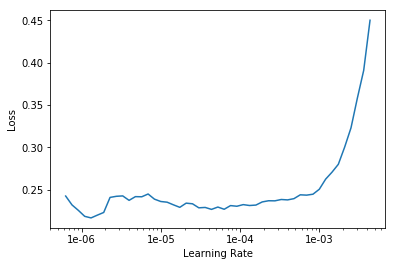

In [ ]:
learn.recorder.plot()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.242544,0.208489,0.067659
2,0.206940,0.204482,0.062246


That's a pretty accurate model! <br>

相当准确的一个模型!

## Training: resnet50 

## 训练:resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).<br>

现在我们将用和之前一样的方式训练模型，但是有一点需要提醒：这次我们将不再使用resnet34作为我们的主干结构，而是使用resnet50。（resnet34是一个34层的残差网络，而resnet50则有50层。本课程后续还会解释，你也可以通过研读[resnet残差网络论文](https://arxiv.org/pdf/1512.03385.pdf)来学习更多的细节）。

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.<br>

通常情况下，resnet50会表现出更好的性能，因为它是一个参数更多、层次更深的网络。我们来看看是否可以获得更好的成绩。为了帮助模型学习，我们使用更大尺寸的图片，这样就会让我们的网络看到更多细节特征。我们稍稍降低batch size，否则这个更大的网络会需要更多的GPU内存（以至于无法使用）。

In [ ]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


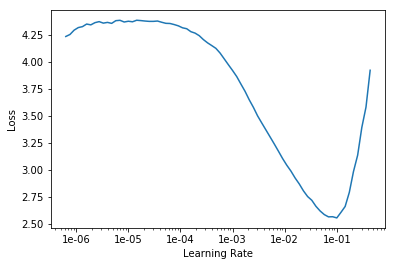

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(8)

Total time: 06:59
epoch  train_loss  valid_loss  error_rate
1      0.548006    0.268912    0.076455    (00:57)
2      0.365533    0.193667    0.064953    (00:51)
3      0.336032    0.211020    0.073072    (00:51)
4      0.263173    0.212025    0.060893    (00:51)
5      0.217016    0.183195    0.063599    (00:51)
6      0.161002    0.167274    0.048038    (00:51)
7      0.086668    0.143490    0.044655    (00:51)
8      0.082288    0.154927    0.046008    (00:51)



In [ ]:
learn.save('stage-1-50')

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:<br>

真是不可思议，模型的宠物品种识别准确率如此之高！我们来看看能否再做一些有帮助的调优：

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

Total time: 03:27
epoch  train_loss  valid_loss  error_rate
1      0.097319    0.155017    0.048038    (01:10)
2      0.074885    0.144853    0.044655    (01:08)
3      0.063509    0.144917    0.043978    (01:08)



If it doesn't, you can always go back to your previous model.<br>

就算调优没有帮助，你也总是能够回退到之前的模型。

In [ ]:
learn.load('stage-1-50');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.most_confused(min_val=2)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('Bengal', 'Egyptian_Mau', 5),
 ('Bengal', 'Abyssinian', 4),
 ('boxer', 'american_bulldog', 4),
 ('Ragdoll', 'Birman', 4),
 ('Egyptian_Mau', 'Bengal', 3)]

## Other data formats 

## 其他的数据格式

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE); path

PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample')

In [ ]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26)

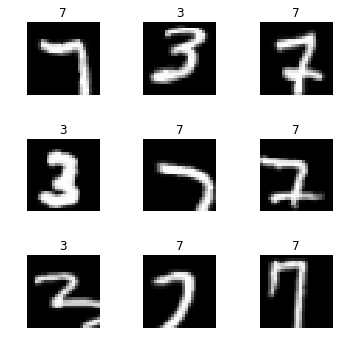

In [ ]:
data.show_batch(rows=3, figsize=(5,5))

In [ ]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit(2)

Total time: 00:23
epoch  train_loss  valid_loss  accuracy
1      0.116117    0.029745    0.991168  (00:12)
2      0.056860    0.015974    0.994603  (00:10)



In [ ]:
df = pd.read_csv(path/'labels.csv')
df.head()

,name,label
0,train/3/7463.png,0
1,train/3/21102.png,0
2,train/3/31559.png,0
3,train/3/46882.png,0
4,train/3/26209.png,0


In [ ]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

[0, 1]

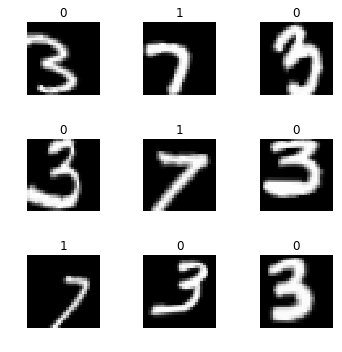

In [ ]:
data.show_batch(rows=3, figsize=(5,5))
data.classes

In [ ]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)
data.classes

[0, 1]

In [ ]:
fn_paths = [path/name for name in df['name']]; fn_paths[:2]

[PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample/train/3/7463.png'),
 PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample/train/3/21102.png')]

In [ ]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)
data.classes

['3', '7']

In [ ]:
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

['3', '7']

In [ ]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

['3', '3', '3', '3', '3']

In [ ]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes

['3', '7']